In [52]:
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from cvxpygen import cpg

In [33]:
# DATA - adjust time to work well.
A = np.array([[1, 1, 0],
              [0, 1, 1],
              [0, 0, 1]])
B = np.array([[0, 0.5, 1]]).T
C = np.array([[-1, 0, 1]])
T = 100
n=3
m=1
p=1
U_max = 0.1
y_des = np.zeros((150, 1)) # add extra zeros for receeding horizon instances
y_des[29:69, :] = 10 #29-70 sets indices 29-68 to 10, corresponding to times t=30 to t = 69

In [47]:
def optimize_traj(
    A: np.ndarray,
    B: np.ndarray,
    C: np.ndarray,
    H: int,
    U_max: float
) -> Tuple[cp.Problem, cp.Parameter, cp.Parameter, cp.Variable]:
    """
    
    Minimize tracking output error.

    LDS given by (MPC form)
    x_{tau + 1} = A @ x_tau + B @ u_tau  tau = t, ..., H-1 
    y_tau = C @ x_tau  tau = t+1, ..., H

    :param A: Dynamics Matrix
    :param B: Control Matrix
    :param C: Output Matrix
    :param H: amount of look-ahead in epochs
    :param U_max: upper bound on input
    """
    n = A.shape[0]
    m = B.shape[1]
    p = C.shape[0]

    x = cp.Variable((n, H+1))
    u = cp.Variable((m, H))

    x_init = cp.Parameter(n)
    y_des = cp.Parameter((H, p))

    # J_output = cp.sum_squares( cp.vstack( [ C@x[:, tau] - y_des[tau + t.value - 1, :]
    #                                        for tau in range(1, H+1)] ) )
    J_output = cp.sum_squares( cp.vstack( [C@x[:, tau] - y_des[tau -1, :]
                                           for tau in range(1, H+1)] ) )
    
    constr = [x[:, 0] == x_init]
    for tau in range(H):
        constr += [ x[:, tau+1] == A@x[:, tau] + B@u[:, tau],
                   cp.norm(u[:, tau], 'inf') <= U_max ]
        
    prob = cp.Problem(cp.Minimize(J_output), constr)
    return (prob, x_init, y_des, u)


In [46]:
y_des[0:, :][10:(10+110), :].shape

(110, 1)

In [56]:
U_traj = np.zeros((m, T))
Y_traj = np.zeros((m, T))
soln_times = np.zeros(T)
J_output = 0
xi = np.zeros(n)

# Initialize problem
parameterized_problem, x_init, y_des_param, u = optimize_traj(A, B, C, 12, U_max)
x_init.value = xi
y_des_param.value = y_des[0:12, :]
parameterized_problem.solve(solver='ECOS')
U_traj[:, 0] = u.value[:, 0]
soln_times[0] = parameterized_problem.solver_stats.solve_time
xi = A@xi + B@u.value[:, 0]
Y_traj[:, 0] = C@xi

for epoch in range(1, T):
    x_init.value = xi
    y_des_param.value = y_des[epoch:(epoch+12), :]
    parameterized_problem.solve(solver='ECOS')
    U_traj[:, epoch] = u.value[:, 0]
    soln_times[epoch] = parameterized_problem.solver_stats.solve_time
    xi = A@xi + B@u.value[:, 0]
    y = C@xi
    Y_traj[:, epoch] = y
    J_output += cp.sum_squares(y - y_des[epoch, :]).value

In [57]:
J_output

119.52482209045469

In [58]:
parameterized_problem.solver_stats.solver_name

'ECOS'

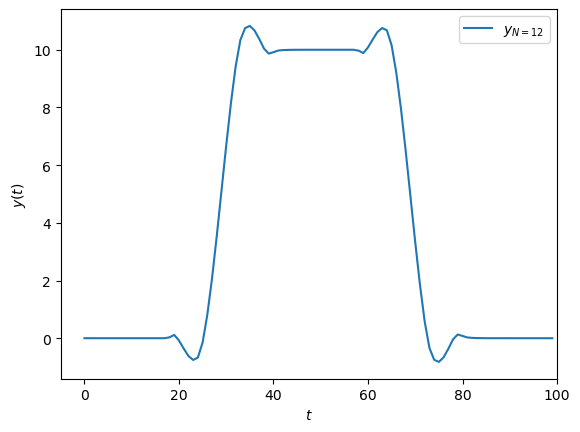

In [50]:
plt.plot(np.arange(T), Y_traj.flatten(), label="$y_{N=12}$")

plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.xlim(right=100)
# plt.title('Output Trajectories')
plt.legend()


plt.show()

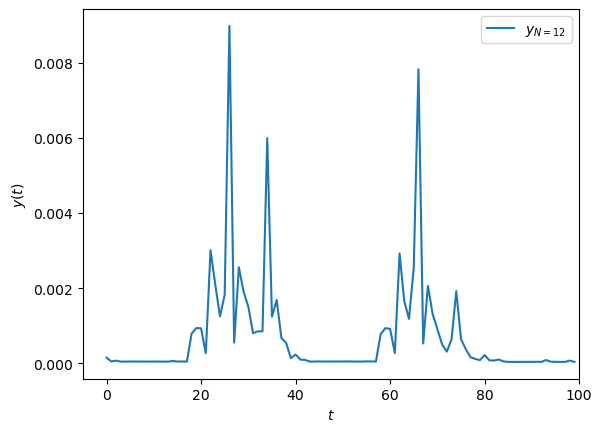

In [51]:
# plt.plot(np.arange(len(y_des)), y_des, label="$y_{\\text{desired}}$")
# plt.plot(np.arange(T), y_traj_opt.flatten(), label="$y_{\\text{opt}}$")
# plt.plot(np.arange(T), y_traj8.flatten(), label="$y_{N=8}$")
# plt.plot(np.arange(T), y_traj10.flatten(), label="$y_{N=10}$")
plt.plot(np.arange(T), soln_times, label="$y_{N=12}$")

plt.xlabel('$t$')
plt.ylabel('$y(t)$')
plt.xlim(right=100)
# plt.title('Output Trajectories')
plt.legend()


plt.show()

# Generate C Code

In [59]:
parameterized_problem, x_init, y_des_param, u = optimize_traj(A, B, C, 12, U_max)
cpg.generate_code(parameterized_problem, code_dir='mpc_controller', solver='ECOS')

Generating code with CVXPYgen ...
CVXPYgen finished generating code.
Compiling python wrapper with CVXPYgen ... 


/Users/q3/opt/anaconda3/envs/boyd_linear-algebra/lib/python3.11/site-packages/setuptools/__init__.py:80: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)


-- The C compiler identification is AppleClang 15.0.0.15000309
-- The CXX compiler identification is AppleClang 15.0.0.15000309
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /Library/Developer/CommandLineTools/usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /Library/Developer/CommandLineTools/usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (7.5s)
-- Generating done (0.1s)
-- Build files have been written to: /Users/q3/Documents/Memex2/Optimization/convex-notes/examples/364b/cvxpygen_test/mpc_controller/c/build
[  3%] Building C object CMakeFiles/cpg.dir/src/cpg_workspace.c.o
[  6%] Building C object CMakeFiles/cpg.dir/src/cpg_solve.c.o
[ 10%] Building C object CMakeFiles/cpg.dir/solver_code/external/amd/sr

/Library/Developer/CommandLineTools/usr/bin/ranlib: file: out/libcpg.a(amd_dump.c.o) has no symbols
/Library/Developer/CommandLineTools/usr/bin/ranlib: file: out/libcpg.a(ctrlc.c.o) has no symbols
/Library/Developer/CommandLineTools/usr/bin/ranlib: file: out/libcpg.a(amd_dump.c.o) has no symbols
/Library/Developer/CommandLineTools/usr/bin/ranlib: file: out/libcpg.a(ctrlc.c.o) has no symbols


[100%] Built target cpg
CVXPYgen finished compiling python wrapper.


ld: warning: duplicate -rpath '/Users/q3/opt/anaconda3/envs/boyd_linear-algebra/lib' ignored
ld: warning: object file (/Users/q3/Documents/Memex2/Optimization/convex-notes/examples/364b/cvxpygen_test/mpc_controller/c/build/out/libcpg.a[2](cpg_workspace.c.o)) was built for newer 'macOS' version (14.0) than being linked (10.9)
ld: warning: object file (/Users/q3/Documents/Memex2/Optimization/convex-notes/examples/364b/cvxpygen_test/mpc_controller/c/build/out/libcpg.a[3](cpg_solve.c.o)) was built for newer 'macOS' version (14.0) than being linked (10.9)
ld: warning: object file (/Users/q3/Documents/Memex2/Optimization/convex-notes/examples/364b/cvxpygen_test/mpc_controller/c/build/out/libcpg.a[4](amd_1.c.o)) was built for newer 'macOS' version (14.0) than being linked (10.9)
ld: warning: object file (/Users/q3/Documents/Memex2/Optimization/convex-notes/examples/364b/cvxpygen_test/mpc_controller/c/build/out/libcpg.a[5](amd_2.c.o)) was built for newer 'macOS' version (14.0) than being linke